Competition kaggle

    _En construction_

Source : https://www.kaggle.com/competitions/spaceship-titanic/data



Dataset
----
train.csv

- Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.

- Age - The age of the passenger.

- VIP - Whether the passenger has paid for special VIP service during the voyage.

- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- Name - The first and last names of the passenger.

- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
----
test.csv 

- Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.
Your task is to predict the value of Transported for the passengers in this set.
-----
sample_submission.csv -

A submission file in the correct format.

- PassengerId - Id for each passenger in the test set.

- Transported - The target. For each passenger, predict either True or False.

In [82]:
import pandas as pd
import missingno as msno
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score,roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Fonctions
## Corrélation

In [83]:
def corr_matrix(df):
    # Increase the size of the heatmap.
    plt.figure(figsize=(16, 6))
    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Dataset

In [84]:
url = './dataset'

train = pd.read_csv(f'{url}/train.csv')
test = pd.read_csv(f'{url}/test.csv')
sample_submission = pd.read_csv(f'{url}/sample_submission.csv')

In [85]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [86]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [87]:
sample_submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


# Fichier train
## Analyse exploratoire

In [88]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [89]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [90]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### Valeurs manquantes

<AxesSubplot: >

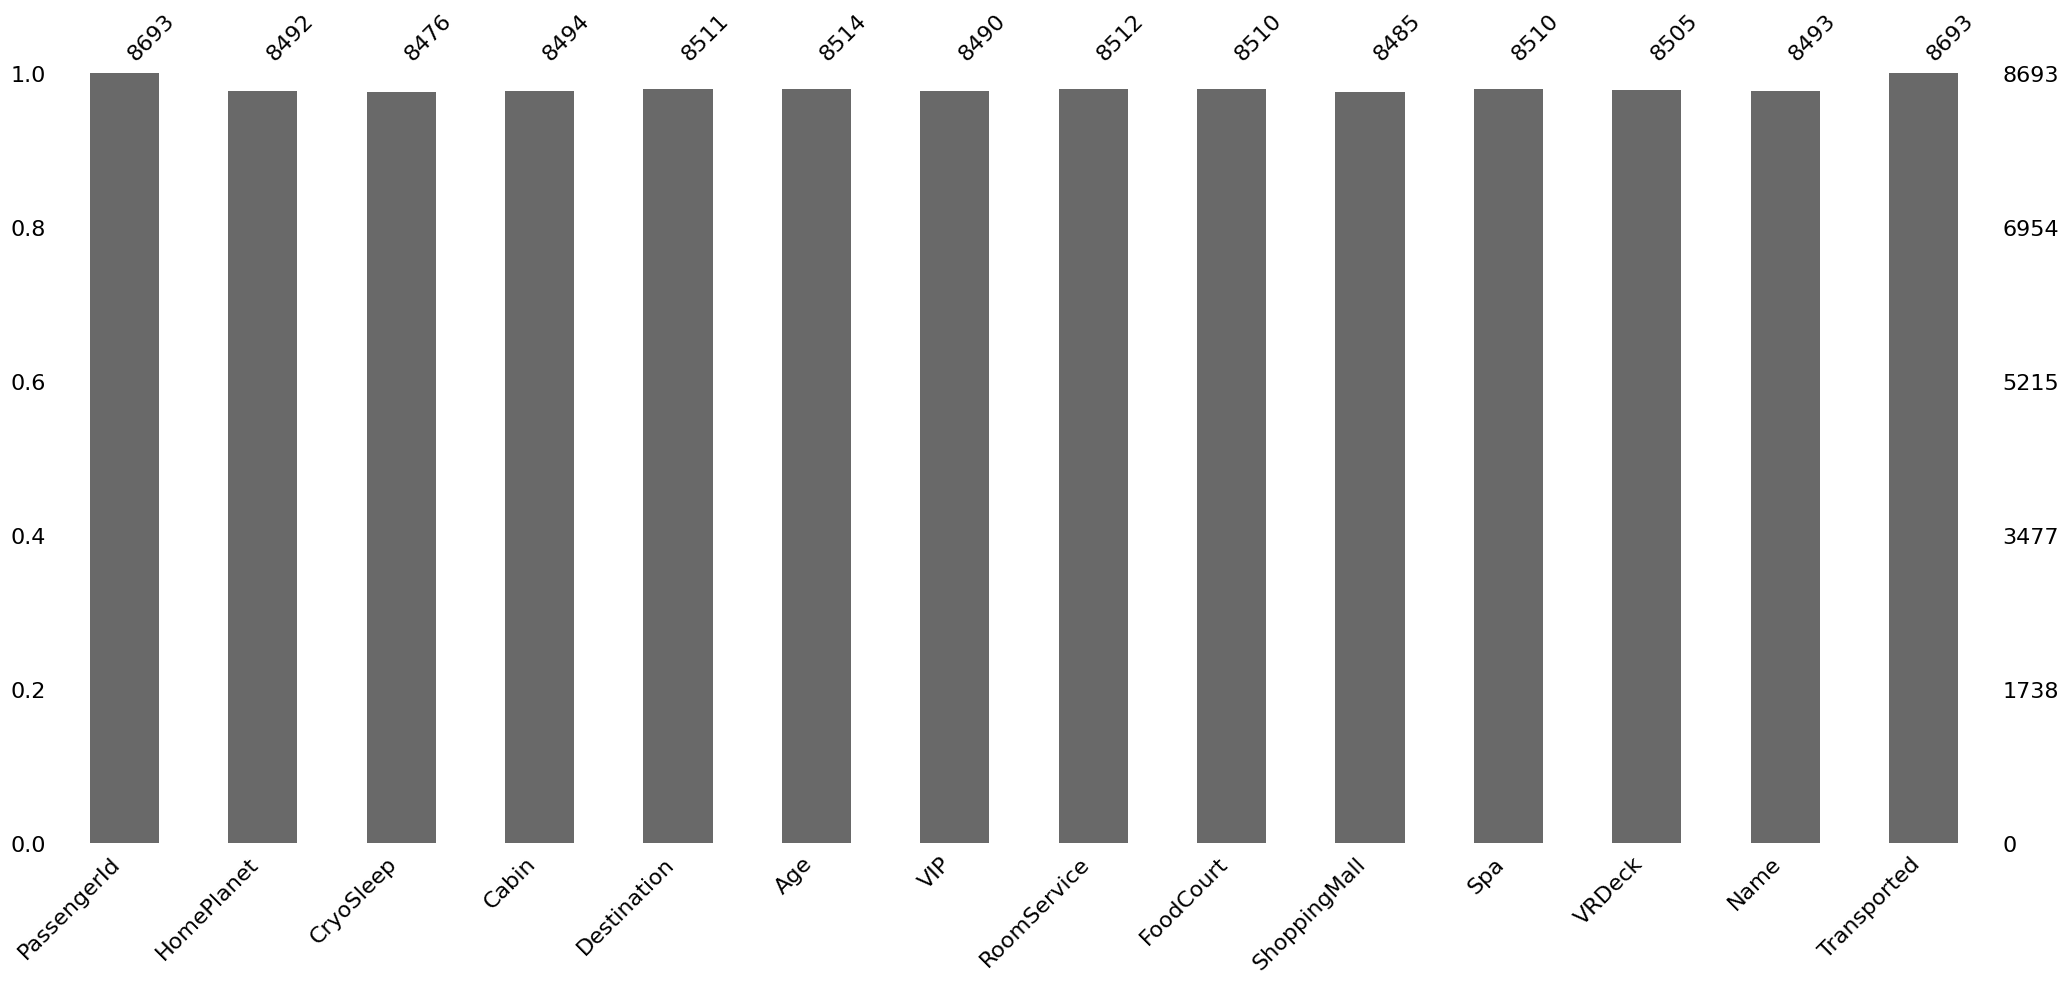

In [91]:
msno.bar(train)

Il y a quelques valeurs manquantes

### Variables
#### Categorical

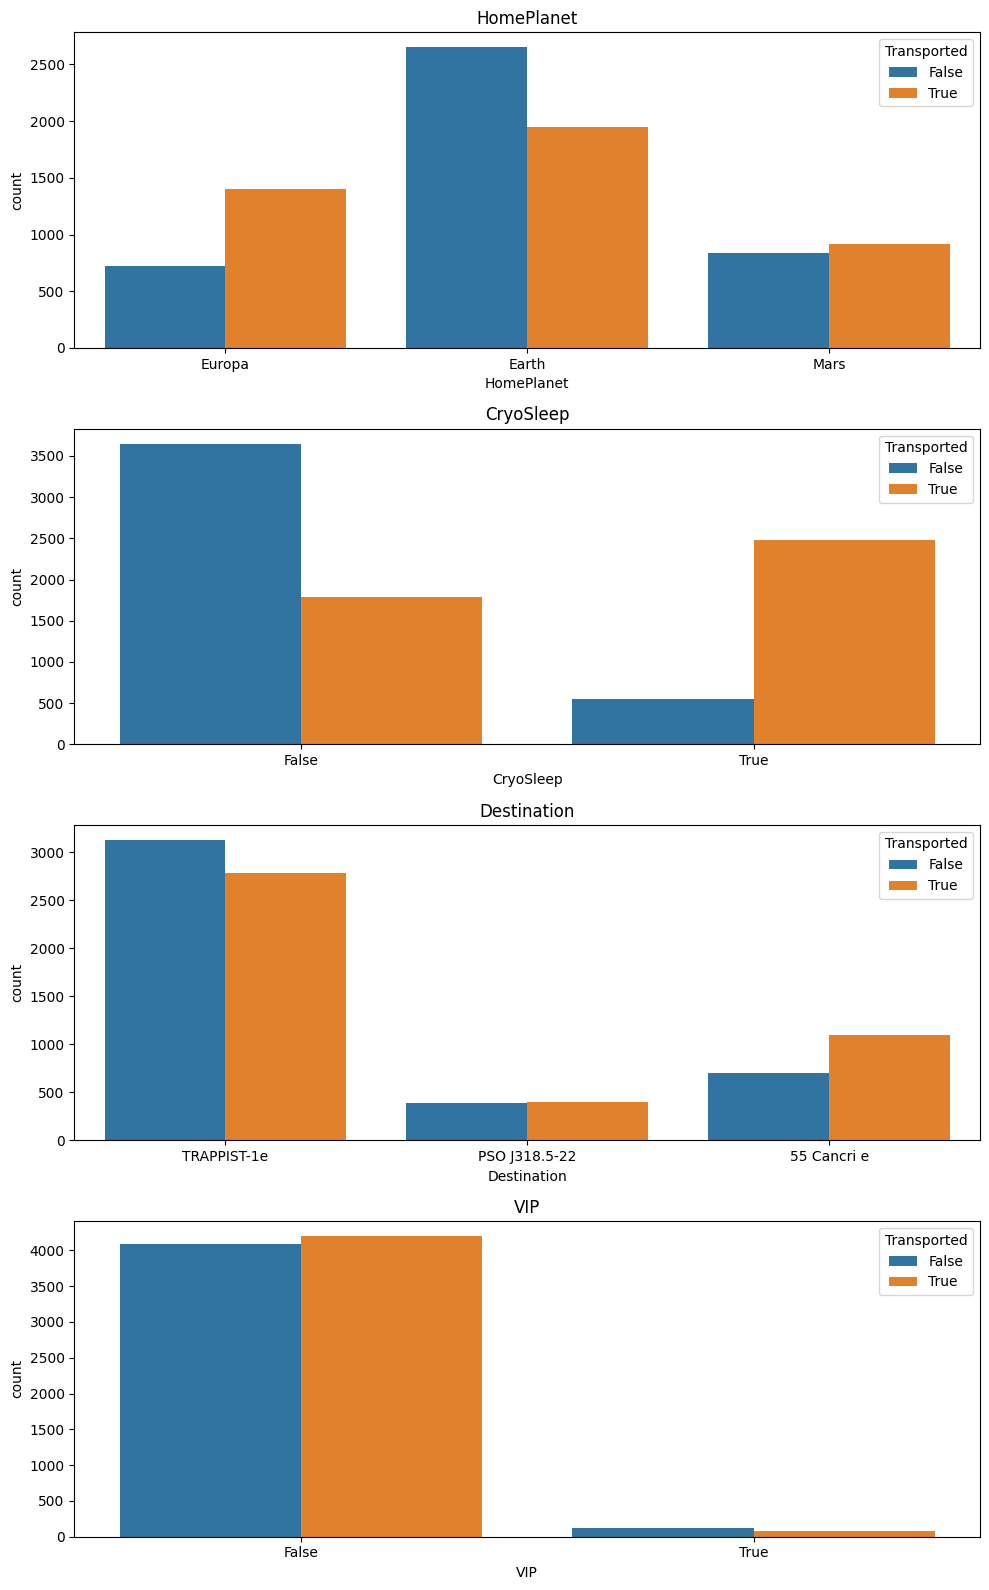

In [92]:
cate = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig = plt.figure(figsize=(10,16))
for i,name in enumerate(cate):
    ax = fig.add_subplot(4,1,i+1)
    sns.countplot(data=train,x=name,hue='Transported',axes=ax)
    ax.set_title(name)
fig.tight_layout()
plt.show()

#### Numerique
##### Age

In [93]:
px.histogram(train, 'Age', nbins=10)

##### VIP ?

In [94]:
px.histogram(train, 'VIP')

### Target
#### Distribution

In [95]:
px.histogram(train, 'Transported')

Le dataset est équilibré.

### Corrélation

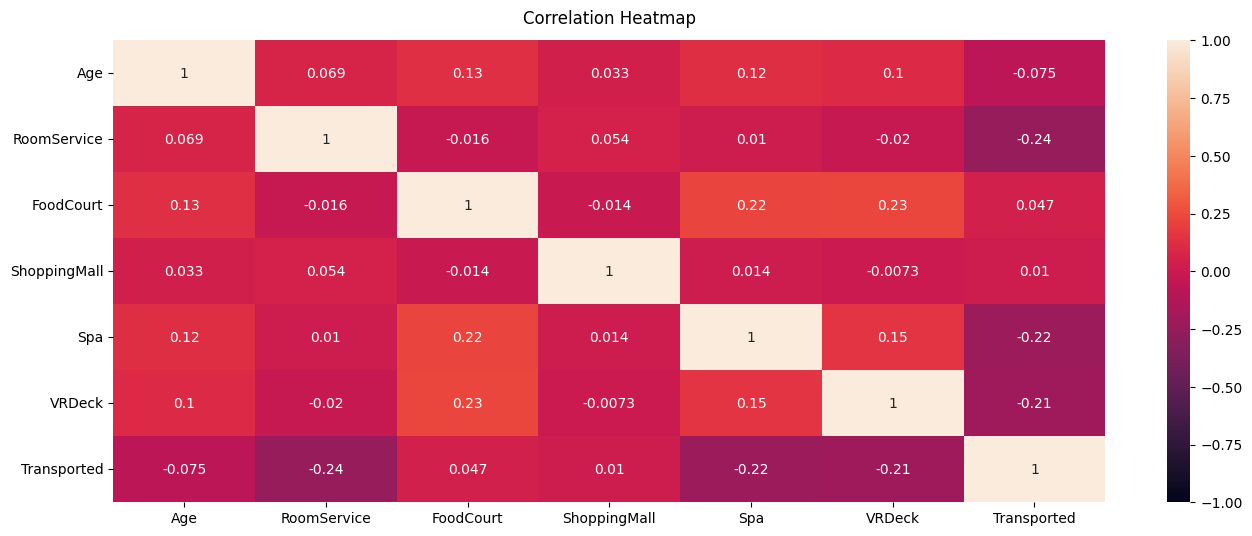

In [96]:
corr_matrix(train)

# Traitement

## Feature engineering

In [97]:
# On découpe le code Cabin.

def feature_engineering(df):
    # La cabine comporte 3 informations, on va les diviser puis supprimer la catégorie
    df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)
    df.drop(['Cabin'], axis=1, inplace=True)
    # on calcule le montant dépensé
    df['Amount_spend'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    
    # pour simplifier le modèle, on va attribuer des groupes d'age.
    # df['Age'] = pd.cut(df['Age'], bins=[0,5,12,18,50,150], labels=['Baby', 'Child', 'Teen', 'Adult', 'Elder'])
    df['Age'] = pd.cut(df['Age'], bins=[0,5,12,18,50,150], labels=[1, 2, 3, 4, 5])
    return df

train = feature_engineering(train)

## Type de variables

In [98]:
colonne_numerique = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
colonne_bool = ['CryoSleep', 'VIP']
colonne_category = ['HomePlanet', 'Destination', 'Age']

def modification_type(df, colonne_category, colonne_numerique, colonne_bool):
    df[colonne_category] = df[colonne_category].astype('category')
    df[colonne_numerique] = df[colonne_numerique].astype('float')
    df[colonne_bool] = df[colonne_bool].astype('bool')
    return df

train = modification_type(train, colonne_category, colonne_numerique, colonne_bool)

In [99]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,Amount_spend
0,0001_01,Europa,False,TRAPPIST-1e,4,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.0
1,0002_01,Earth,False,TRAPPIST-1e,4,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,736.0
2,0003_01,Europa,False,TRAPPIST-1e,5,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,4,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,3,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,4,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P,8536.0
8689,9278_01,Earth,True,PSO J318.5-22,3,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S,0.0
8690,9279_01,Earth,False,TRAPPIST-1e,4,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S,1873.0
8691,9280_01,Europa,False,55 Cancri e,4,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S,4637.0


## Valeurs manquantes


On a vu précédemment que certaines valeurs étaient manquantes. On va donc corriger cela.

In [100]:
def correction_valeurs_manquantes(df : pd.DataFrame, colonnes):
    for colonne in colonnes:
        df[colonne].fillna(df[colonne].median(), inplace=True)
    return df

# On ne va toucher qu'aux colonnes numériques, car il est impossible de déterminer la cabine ou la destination à partir de la médiane.
df_train = correction_valeurs_manquantes(train,colonne_numerique)

<AxesSubplot: >

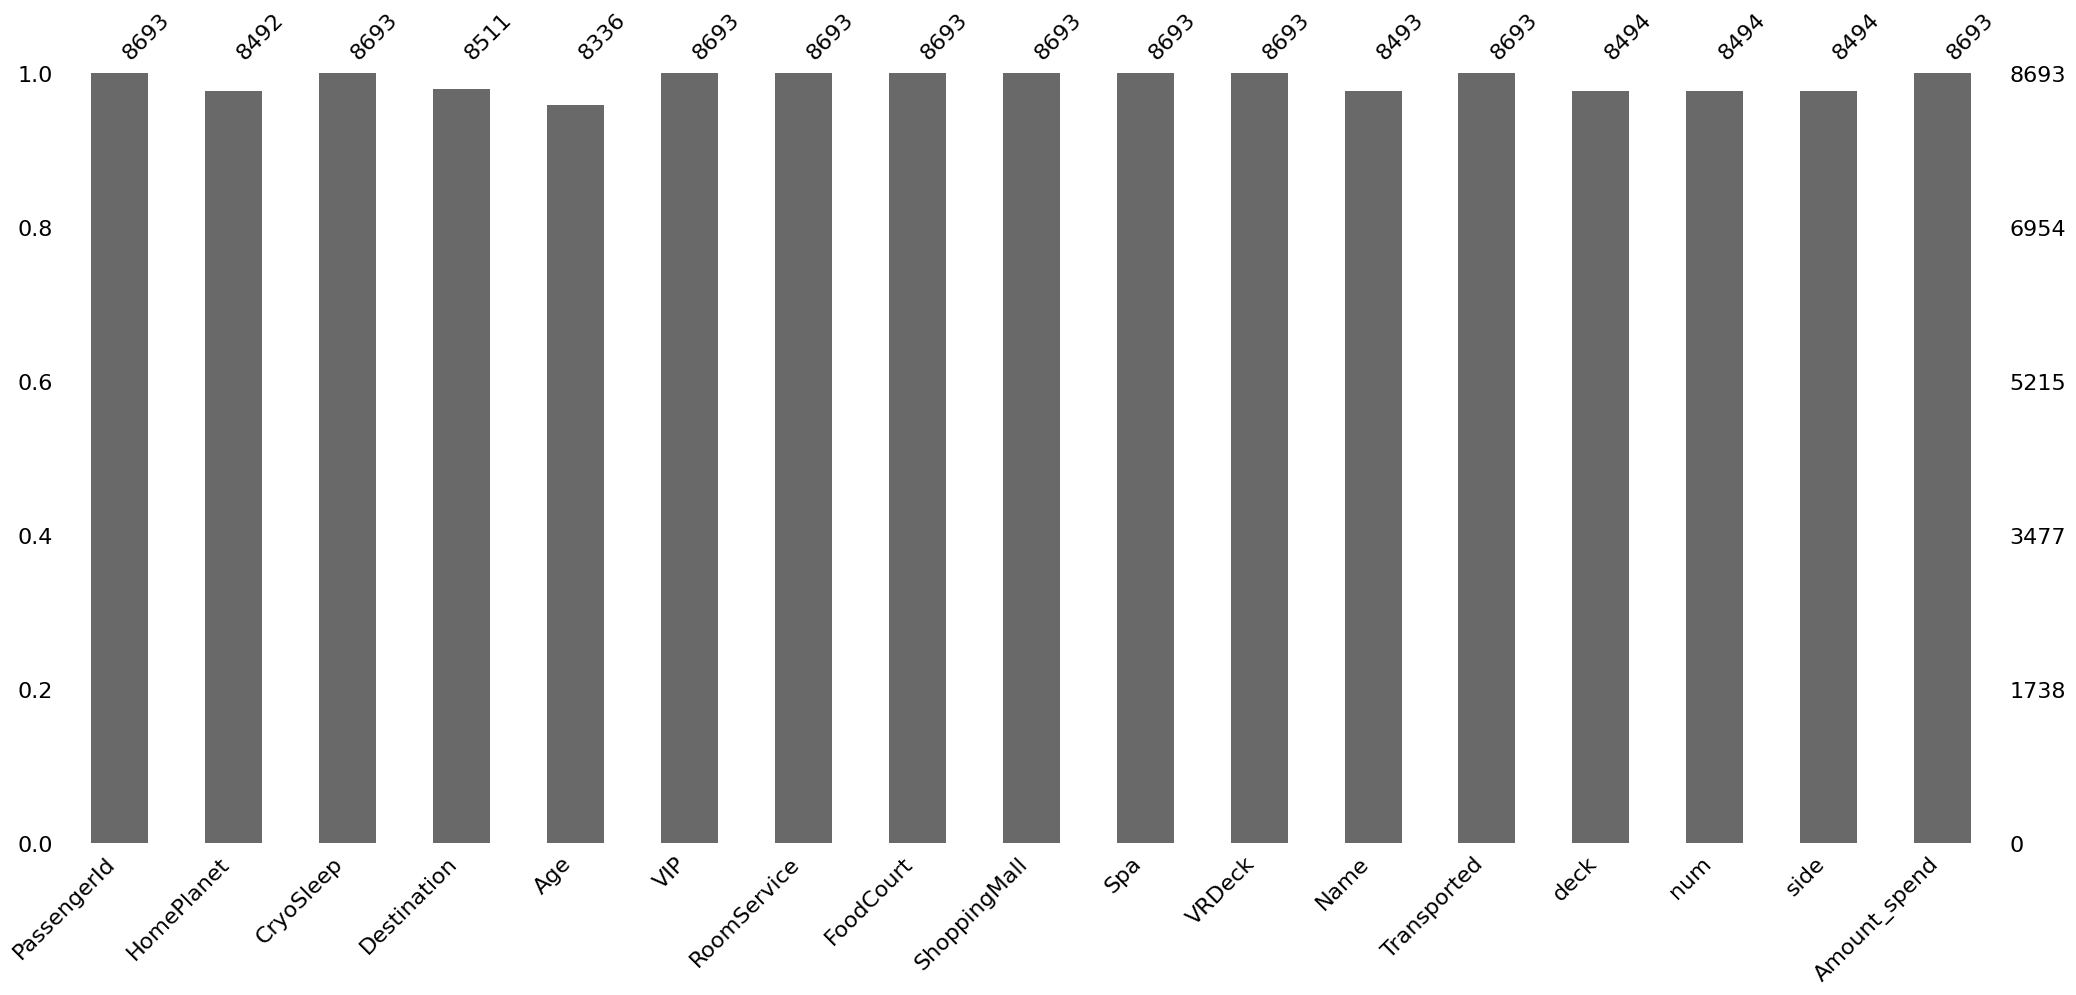

In [101]:
msno.bar(df_train)

In [102]:
# On supprime les lignes ayant encore des NA
df_train.dropna(inplace=True)

print(f'Il nous reste {df_train.shape[0]} lignes.')

Il nous reste 7606 lignes.


In [103]:
df_train.dtypes

PassengerId       object
HomePlanet      category
CryoSleep           bool
Destination     category
Age             category
VIP                 bool
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Transported         bool
deck              object
num               object
side              object
Amount_spend     float64
dtype: object

# Modélisation

## Fonctions

In [104]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
def preparation_pipeline():
    numerical_pipeline = make_pipeline(StandardScaler())
    categorical_pipeline = make_pipeline(OneHotEncoder(
        handle_unknown='infrequent_if_exist', sparse_output=False))

    numerical_features = make_column_selector(dtype_include=[np.number, bool])
    categorical_features = make_column_selector(
        dtype_exclude=[np.number, bool])

    preprocessing = make_column_transformer((numerical_pipeline, numerical_features),
                                            (categorical_pipeline, categorical_features),
                                            (KNNImputer(), ['Age'])) # Pour déterminer les groupes d'âge manquant

    return preprocessing


def score_summary(names, classifiers, df):
    '''
    Given a list of classiers, this function calculates the accuracy, 
    ROC_AUC and Recall and returns the values in a dataframe


    Exemple ---

    >>> score_summary(names, classifiers).sort_values(by='Accuracy' , ascending = False)\

    >>> .style.background_gradient(cmap='coolwarm')\

    >>> .bar(subset=["ROC_AUC",], color='#6495ED')\

    >>> .bar(subset=["Recall"], color='#ff355d')\

    >>> .bar(subset=["Precision"], color='lightseagreen')\

    >>> .bar(subset=["F1"], color='gold')
    '''

    X = df.drop(['Transported', 'PassengerId'], axis=1)
    y = df['Transported']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0, stratify=y)

    cols = ["Classifier", "Accuracy", "ROC_AUC Test",
            "ROC_AUC Train", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)

    preprocessing = preparation_pipeline()

    for name, clf in zip(names, classifiers):
        pipe = make_pipeline(preprocessing,
                             clf)

        pipe.fit(X_train, y_train)

        pred = pipe.predict(X_test)
        pred = pred.astype(y_test.dtype)
        accuracy = accuracy_score(y_test, pred)

        pred_proba_test = pipe.predict_proba(X_test)[:, 1]
        pred_proba_train = pipe.predict_proba(X_train)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
        # roc_auc = auc(fpr, tpr)

        roc_auc_test = roc_auc_score(y_test, pred_proba_test)
        roc_auc_train = roc_auc_score(y_train, pred_proba_train)

        # confusion matric, cm
        cm = confusion_matrix(y_test, pred)

        # recall: TP/(TP+FN)
        recall = cm[1, 1]/(cm[1, 1] + cm[1, 0])

        # precision: TP/(TP+FP)
        precision = cm[1, 1]/(cm[1, 1] + cm[0, 1])

        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc_test,
                          roc_auc_train, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)

    return data_table.reset_index(drop=True)


def roc_auc_curve(names, classifiers, df):
    '''
    Given a list of classifiers, this function plots the ROC curves

    '''

    X = df.drop(['Transported', 'PassengerId'], axis=1)
    y = df['Transported']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0, stratify=y)

    plt.figure(figsize=(12, 8))

    preprocessing = preparation_pipeline()

    for name, clf in zip(names, classifiers):
        pipe = make_pipeline(preprocessing,
                             clf)
        pipe.fit(X_train, y_train)

        pred_proba = pipe.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        roc_auc = roc_auc_score(y_test, pred_proba)

        plt.plot(fpr, tpr, lw=3, label=name +
                 ' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")

## Evaluation

In [105]:
names =[
    'Catboost',
    'xgbbost',
    'lightGBM',
    'Random Forest',
    'LR',
    'Decision Tree',
    'LDA',
    'GradiantBoosting'
]

seed = 0

classifiers = [
    CatBoostClassifier(random_state=seed, verbose=0),
    XGBClassifier(objective= 'binary:logistic', random_state=seed),
    LGBMClassifier(),
    RandomForestClassifier(random_state=seed),
    LogisticRegression(solver="liblinear", random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
   ]

In [106]:
# score_summary(names, classifiers, df_train)

In [107]:
# roc_auc_curve(names, classifiers, df_train)

In [108]:
xgb = XGBClassifier(objective= 'binary:logistic', random_state=seed)

preprocessing = preparation_pipeline()

X = df_train.drop(['Transported', 'PassengerId'], axis=1)
y = df_train['Transported']


preprocessing = preparation_pipeline()


pipe = make_pipeline(preprocessing,
                             xgb)

pipe.fit(X, y)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026B86867EB0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  <skle...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

# Prediction

On refait le feature engineering précédent

In [109]:
test = feature_engineering(test)
test = modification_type(test, colonne_category, colonne_numerique, colonne_bool)
test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Amount_spend
0,0013_01,Earth,True,TRAPPIST-1e,4,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,0.0
1,0018_01,Earth,False,TRAPPIST-1e,4,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,2832.0
2,0019_01,Europa,True,55 Cancri e,4,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,0.0
3,0021_01,Europa,False,TRAPPIST-1e,4,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,7418.0
4,0023_01,Earth,False,TRAPPIST-1e,4,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,4,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S,0.0
4273,9269_01,Earth,False,TRAPPIST-1e,4,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,NaN,NaN,1018.0
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P,0.0
4275,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P,3203.0


In [110]:
test['Transported'] = pipe.predict(test)
test['Transported'] = test['Transported'].astype(bool)

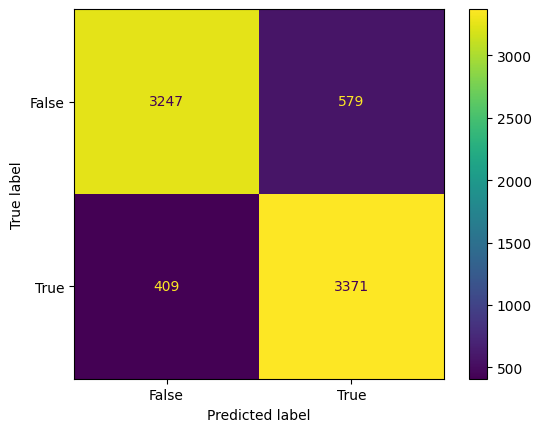

In [111]:
X_comparaison = X.copy()

X_comparaison['predict'] = pipe.predict(X_comparaison)

cm = confusion_matrix(y, X_comparaison['predict'], labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipe.classes_)

disp.plot()

plt.show()

### Optimisation

In [112]:
from sklearn.model_selection import GridSearchCV

PARAMETERS = {"xgb__subsample":[0.75, 1],
"xgb__colsample_bytree":[0.75, 1],
"xgb__max_depth":[2, 6],
"xgb__min_child_weight":[1, 5],
"xgb__learning_rate":[0.1, 0.01]}

pipe = make_pipeline(preprocessing,
                             xgb)

pipe_grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=PARAMETERS)

In [113]:
test['Transported'] = pipe.predict(test)
test['Transported'] = test['Transported'].astype(bool)

submission = test[['PassengerId', 'Transported']]
submission.to_csv('submission_v6.csv', index=False)